## Package

In [1]:
%matplotlib notebook

import sys, os, time
from pathlib import Path
#from tqdm import tqdm

from matplotlib import pyplot as plt
import numpy as np
import fabio
import pyFAI

import multiprocessing as mp

sys.path.append('Functions')

## Paths


In [2]:
path_proj = Path('')

path_raw = Path(path_proj, "raw") # Detector images
path_ut = Path(path_proj, "utilities")  # Utilities (e.g. .poni)
path_int = Path(path_proj, "integrated") # For integrated frames

# Load the geometry and mask

In [3]:
# path geometry (pyFAI)
geom_path = Path(path_ut, 'geom1.poni')

# path mask (pyFAI)
mask_path = Path(path_ut, "mask_spec.edf")
mask = fabio.open(mask_path).data


# Let's load the .poni 
ai = pyFAI.load(str(geom_path))

print(f"Geometry loaded ({geom_path})")
print('----------')
print(ai)
print('----------')

Geometry loaded (utilities/geom1.poni)
----------
Detector Pilatus 2M	 PixelSize= 1.720e-04, 1.720e-04 m
Wavelength= 1.423358e-11m
SampleDetDist= 1.404152e+00m	PONI= 2.752789e-01, 2.288678e-02m	rot1=-0.017484  rot2= 0.000941  rot3= 0.000000 rad
DirectBeamDist= 1404.367mm	Center: x=275.813, y=1608.146 pix	Tilt=1.003 deg  tiltPlanRotation= 3.082 deg
----------


## Let's compare sequential and parallel

#### Define the function for parallel (open image + integration)

In [4]:
def integ_azm(IMG_path, save_folder, N_pts, r_rng, save_txt=True):
    # paths...
    fileName = IMG_path.stem + ".dat"
    save_path = Path(save_folder, fileName) 

    # Open the image
    IMG = fabio.open(IMG_path).data

    #  Azimuthal integration
    if save_txt:
        res = ai.integrate1d(IMG,
                             npt = N_pts,
                             unit = "2th_deg", # We want to use 2 theta in degree 
                             mask = mask, # (1 for masked pixels, and 0 for valid pixels is the pyFAI standard)
                             radial_range = r_rng,
                             filename = save_path)
    else:
        res = ai.integrate1d(IMG,
                             npt = N_pts,
                             unit = "2th_deg", # We want to use 2 theta in degree 
                             mask = mask, # (1 for masked pixels, and 0 for valid pixels is the pyFAI standard)
                             radial_range = r_rng)
        
    return (res.radial, res.intensity)

#### Make both integration (sequential and parallel) and compare the elapsed time

In [5]:
# Secimen info
# ------
# List of files to integrate
IMG_path_list = path_raw.glob("*.cbf")
IMG_path_list = [x for x in IMG_path_list if x.is_file()]

# Radial range
r_rng = [0.6, 13.5] # deg

# Integration point per detector pixel (can be less than 1)
pix_per_pts = 1

# Save the .dat (text) files of PyFAI ?
saving_txt_files = False


# ----------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------

# Number of integration points calculation
pix_size = ai.pixel1 # pixel size of the detector (m)
D = ai.dist # Distance between the sample and the detecor (m)
r_lenght = r_rng[1] - r_rng[0] # deg
Dtheta_pix = np.arctan(pix_size/D) * (180/np.pi) # size of a pixel in terms of 2theta (deg)
N_pts = int(r_lenght/(pix_per_pts * Dtheta_pix))


# Seqential integration
# ------
print("Seqential computing...")
save_folder = Path(path_int, 'test_seq')
save_folder.mkdir(parents=True, exist_ok=True) # Make dir if not exist

t0 = time.time()
res_seq = [integ_azm(IMG_path, save_folder, N_pts, r_rng, save_txt=saving_txt_files) for IMG_path in IMG_path_list]
tf = time.time()
elapsed_time_seq = tf - t0


# Parallel integration
# ------
print("Parallel computing...")
save_folder = Path(path_int, 'test_para')
save_folder.mkdir(parents=True, exist_ok=True) # Make dir if not exist

t0 = time.time()
pool = mp.Pool(mp.cpu_count()) # Init multiprocessing.Pool()

res_para = pool.starmap(integ_azm, [(IMG_path, save_folder, N_pts, r_rng, saving_txt_files) for IMG_path in IMG_path_list])

pool.close() # close the pool
tf = time.time()
elapsed_time_para = tf - t0


print('***********************************')
print(f"Elapsed time Seqential: {elapsed_time_seq} sec")
print(f"Elapsed time Parallel:  {elapsed_time_para} sec")
print('***********************************')

Seqential computing...
Parallel computing...
***********************************
Elapsed time Seqential: 3.6687631607055664 sec
Elapsed time Parallel:  2.009899616241455 sec
***********************************


## Plot to check


<IPython.core.display.Javascript object>


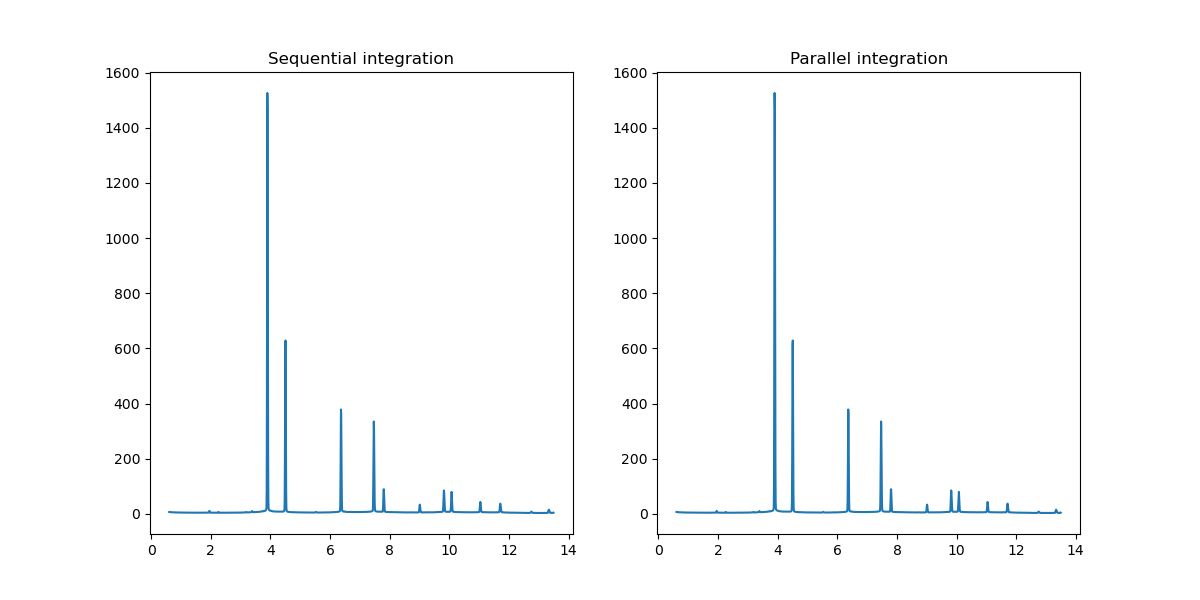

In [6]:
ii_plt = 0

plt.figure(figsize=(12, 6))
ax1 = plt.subplot(1,2,1)
ax1.plot(res_seq[ii_plt][0], res_seq[ii_plt][1])
plt.title('Sequential integration')

ax2 = plt.subplot(1,2,2, sharex=ax1, sharey=ax1)
ax2.plot(res_para[ii_plt][0], res_para[ii_plt][1])
plt.title('Parallel integration')

plt.show()

